# llc4320 drifters spectra: Lagrangian

In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
from cmocean import cm
import dask.dataframe as dd
from xhistogram.xarray import histogram

%matplotlib inline
from matplotlib import pyplot as plt
import mitequinox.utils as ut
import mitequinox.parcels as pa
import mitequinox.drifters as dr

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.5708892.datarmor0/parcels-502027/libparcels_random_be3df7a8-f2b4-4567-8049-41507ec955e4.so


In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster()
    cluster = PBSCluster() # necessary?
    w = cluster.scale(jobs=3)
    # 3 needed for lagrangian lon/lat binning
    # 15 for eulerian binning
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

In [3]:
client

Client Scheduler: tcp://10.148.0.221:60759 Dashboard: http://10.148.0.221:8787/status,Cluster Workers: 112 Cores: 112 Memory: 1.75 TiB


---
# Lagrangian spectra
### last update: 2021.07.07

## 1. Zonal averaging

In [4]:
# load Lagrangian data
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['trajectory'])

In [18]:
V = ["mean0","mean1","mean2"]

for v in V:

    # read raw spectra
    df = p.load_diagnostic('spectra_uv_T60_%s'%(v))
    df.head()

    # add bathymetry to dataframe
    def interp_bathy(df):
        bathy = ut.load_bathy(15)
        ds = df[['lon','lat']].to_xarray()
        ds_interpolated = bathy.interp(lon=ds['lon'], lat=ds['lat'])
        df_interpolated = ds_interpolated.to_dataframe()[bathy.name]
        return df.assign(**{bathy.name: df_interpolated})

    df = df.map_partitions(interp_bathy)

    # filter out depth ranges
    df = df[df['h']>500]
    df.head()

    # bin geographically
    dl = 1.
    lat_bins = np.arange(-60, 60, dl)

    df['lat_cut'] = df['lat'].map_partitions(pd.cut, bins=lat_bins)

    E = df.groupby(['lat_cut']).mean().compute()

    #Converting pandas dataframe in xarray dataset:
    ds = (pd.melt(E.set_index(E.index.map(lambda v: v.mid))
                  .drop(columns=['time','lon','lat', 'h'])
                  .reset_index(), 
                  id_vars=['lat_cut',], 
                  var_name='frequency')
                  .rename(columns={'lat_cut': 'lat_bins', 
                                   'value': 'E'},
                         )
         ).to_xarray().set_index(index=['lat_bins','frequency']).unstack()
    ds['frequency'] = ds['frequency'].astype(float)
    ds = ds.sortby('frequency')

    p.store_diagnostic('spectra_uv_T60_%s_lat'%(v), ds, overwrite=True)

spectra_uv_T60_mean0_lat diagnostics stored in /home/datawork-lops-osi/equinox/mit4320/parcels/global_extra_T365j_dt1j_dij50/diagnostics/spectra_uv_T60_mean0_lat.zarr
spectra_uv_T60_mean1_lat diagnostics stored in /home/datawork-lops-osi/equinox/mit4320/parcels/global_extra_T365j_dt1j_dij50/diagnostics/spectra_uv_T60_mean1_lat.zarr
spectra_uv_T60_mean2_lat diagnostics stored in /home/datawork-lops-osi/equinox/mit4320/parcels/global_extra_T365j_dt1j_dij50/diagnostics/spectra_uv_T60_mean2_lat.zarr


## Plots

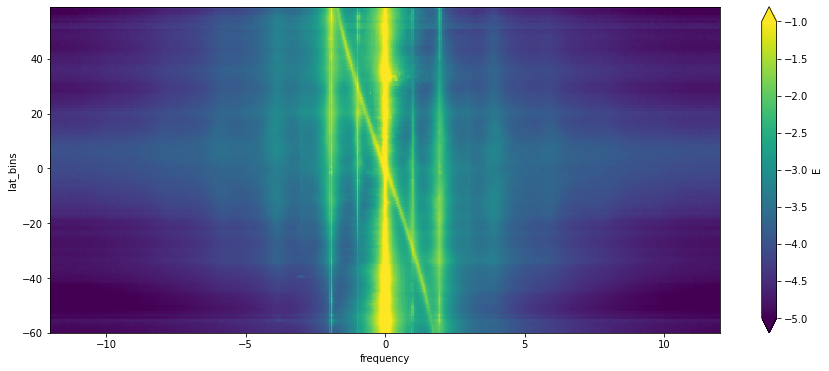

In [20]:
# no detrending
ds = p.load_diagnostic('spectra_uv_T60_mean0_lat.zarr')

# spectra_raw_uv_mean1_lat_xyu
fig, ax = plt.subplots(figsize=(15,6))
ax = plt.subplot(111)
np.log10(ds.E).plot(cmap='viridis', vmin=-5, vmax=-1)

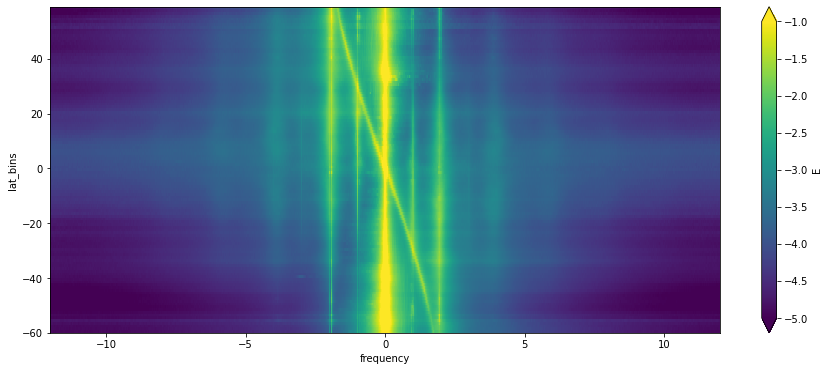

In [21]:
# no detrending
ds = p.load_diagnostic('spectra_uv_T60_mean1_lat.zarr')

# spectra_raw_uv_mean1_lat_xyu
fig, ax = plt.subplots(figsize=(15,6))
ax = plt.subplot(111)
np.log10(ds.E).plot(cmap='viridis', vmin=-5, vmax=-1)

---
## 2. lat x lon binning

In [ ]:
V = ["mean0","mean1","mean2"]

for v in V:

    # read raw Lagrangian spectra
    df = p.load_diagnostic('spectra_uv_T60_%s'%(v))
    df.head()

    # add bathymetry to dataframe
    def interp_bathy(df):
        bathy = ut.load_bathy(15)
        ds = df[['lon','lat']].to_xarray()
        ds_interpolated = bathy.interp(lon=ds['lon'], lat=ds['lat'])
        df_interpolated = ds_interpolated.to_dataframe()[bathy.name]
        return df.assign(**{bathy.name: df_interpolated})
    df = df.map_partitions(interp_bathy)

    # filter out depth ranges
    df = df[df['h']>500]
    df.head()

    # bin geographically
    dl = 1.
    lon_bins = np.arange(-180.,180., dl)
    lat_bins = np.arange(-90, 90, dl)
    df['lon'] = (df['lon']+180)%360 - 180
    df['lon_cut'] = df['lon'].map_partitions(pd.cut, bins=lon_bins)
    df['lat_cut'] = df['lat'].map_partitions(pd.cut, bins=lat_bins)
    df = df.reset_index().persist()
    E = df.groupby(['lon_cut', 'lat_cut']).mean().compute()
    
    #Converting pandas dataframe in xarray dataset:
    index = pd.MultiIndex.from_arrays([E.index.map(lambda v: v[0].mid),
                                       E.index.map(lambda v: v[1].mid)
                                      ], 
                                      names=('lon_cut', 'lat_cut'),
                                     )
    ds = (pd.melt(E.set_index(index)
                  .drop(columns=['time','lon','lat', 'h'])
                  .reset_index(), id_vars=['lon_cut', 'lat_cut',],
                  var_name='frequency',
                 )
          .rename(columns={'lon_cut': 'lon_bins', 'lat_cut': 'lat_bins', 'value': 'E'})
         ).to_xarray().set_index(index=['lon_bins', 'lat_bins','frequency']).unstack()
    ds['frequency'] = ds['frequency'].astype(float)
    ds = ds.sortby('frequency')
    ds = ds.chunk({'frequency': 100})

    # store diagnostic
    p.store_diagnostic('spectra_uv_T60_%s_lat_lon_1deg'%(v), ds, overwrite=True)    

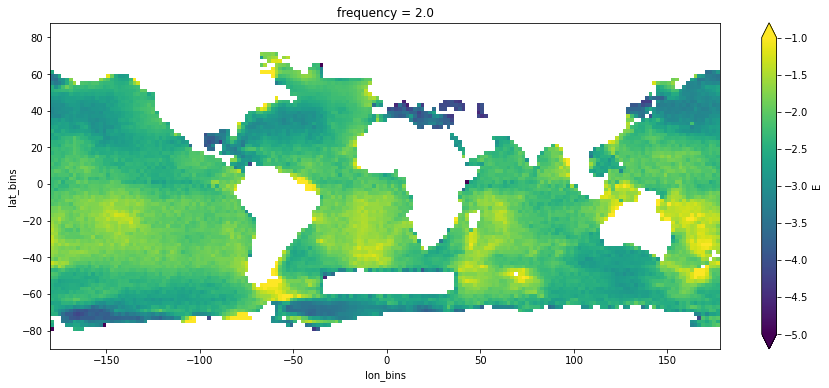

In [7]:
# load spectra
ds = p.load_diagnostic('spectra_uv_T60_mean0_lat_lon.zarr')
fig, ax = plt.subplots(figsize=(15,6))
ax = plt.subplot(111)
np.log10(ds.E.sel(frequency=2)).plot(x='lon_bins',cmap='viridis', vmin=-5, vmax=-1)

_____________
## 3. lon x lat for band-integrated KE

In [37]:
V = ["mean0","mean1","mean2"]

for v in V:
    
    ds = p.load_diagnostic('spectra_uv_T60_%s_lat_lon.zarr'%(v))

    f_llc = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(ds.lat_bins))
    f_cpd_llc = f_llc*86400/2./np.pi

    bands = {'low': (0., .5), 'diurnal': (0.9, 1.1), 'semidiurnal': (1.9, 2.1), 'inertial':(f_cpd_llc.values.min(),f_cpd_llc.values.max())}
    domega = float(ds.frequency[1]- ds.frequency[0])

    Eb = {}
    for b, bounds in bands.items():
        #print('Frequency band {}, frequency bounds: {}-{} cpd'.format(b, bounds[0], bounds[1]))

        if b == "inertial":
            _E = ds.E.where((np.abs(ds.frequency + f_cpd_llc)<=0.1), 
                        drop=False,
                       )

        else:
            _E = ds.E.where((np.abs(ds.frequency)>=bounds[0]) & (np.abs(ds.frequency)<=bounds[1]), 
                            drop=False,
                           )

        E = domega * _E.sum('frequency')    
        Eb[b] = E.persist()

    # converts to single dataset and store:
    E = xr.concat(list(Eb.values()), 
                  dim=pd.Index(list(Eb.keys()),name='frequency_band'),
                 )

    # store diagnostic
    p.store_diagnostic('spectra_uv_T60_%s_lat_lon_bands'%(v), E.to_dataset(), overwrite=True)

spectra_uv_T60_mean0_lat_lon_bands diagnostics stored in /home/datawork-lops-osi/equinox/mit4320/parcels/global_extra_T365j_dt1j_dij50/diagnostics/spectra_uv_T60_mean0_lat_lon_bands.zarr
spectra_uv_T60_mean1_lat_lon_bands diagnostics stored in /home/datawork-lops-osi/equinox/mit4320/parcels/global_extra_T365j_dt1j_dij50/diagnostics/spectra_uv_T60_mean1_lat_lon_bands.zarr
spectra_uv_T60_mean2_lat_lon_bands diagnostics stored in /home/datawork-lops-osi/equinox/mit4320/parcels/global_extra_T365j_dt1j_dij50/diagnostics/spectra_uv_T60_mean2_lat_lon_bands.zarr


In [39]:
# load spectra
ds = p.load_diagnostic('spectra_uv_T60_mean0_lat_lon_bands.zarr')
ds

<xarray.Dataset>
Dimensions:         (frequency_band: 4, lat_bins: 89, lon_bins: 179)
Coordinates:
  * frequency_band  (frequency_band) object 'low' 'diurnal' ... 'inertial'
  * lat_bins        (lat_bins) float64 -89.0 -87.0 -85.0 ... 83.0 85.0 87.0
  * lon_bins        (lon_bins) float64 -179.0 -177.0 -175.0 ... 175.0 177.0
Data variables:
    E               (frequency_band, lon_bins, lat_bins) float64 dask.array<chunksize=(1, 179, 89), meta=np.ndarray>

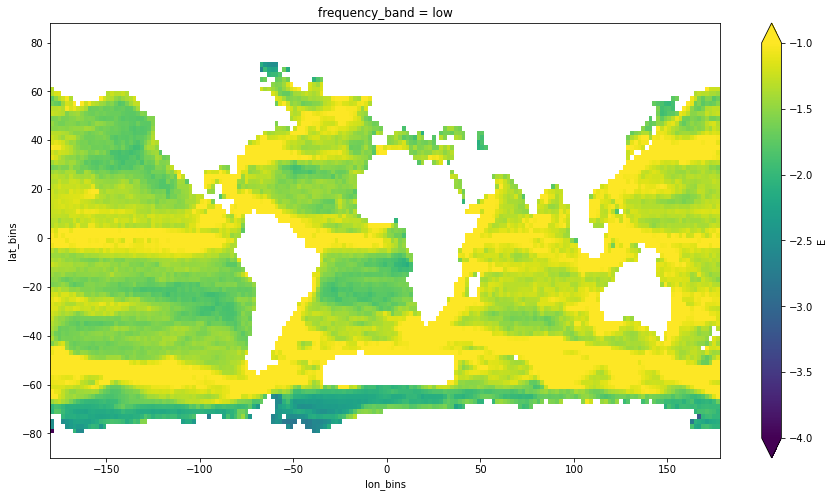

In [40]:
fig, ax = plt.subplots(figsize=(15,8))
ax = plt.subplot(1,1,1)
np.log10(ds.E).sel(frequency_band='low').plot(x='lon_bins',y='lat_bins',vmin=-4,vmax=-1)

## Close cluster

In [7]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
